In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
from AUC import AUC
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X_train,X_test,Y_train, Y_test = load_data()
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

print (Y_train.dtype)
#lab_data = rgb2lab(Y_train)

mean_val = np.mean(Y_train)
print (np.max(Y_train))
print (np.min(Y_train))
print (mean_val)
#Y_train = Y_train - mean_val
print (np.max(Y_train))
print (np.min(Y_train))
#print (lab_data.shape) 
#lab_data,mean_dat,std_dat = normalise_train(lab_data)

0
(481, 64, 64, 1)
(121, 64, 64, 1)
(481, 64, 64, 3)
(121, 64, 64, 3)
uint8
255
0
100.059860811
255
0


In [3]:
def show_images(images,gray = False):

    
    if(gray):
        plt.imshow(images,cmap = plt.get_cmap('gray'))
    else :
        plt.imshow(images);

    plt.show()

(481, 64, 64, 3)
INFO:tensorflow:Restoring parameters from ../models/image_net_pok_model_trained/new_model
0.0168174


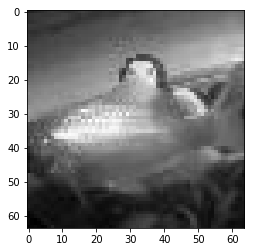

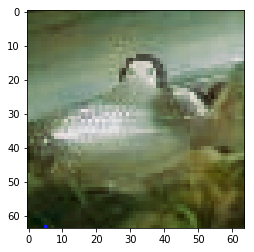

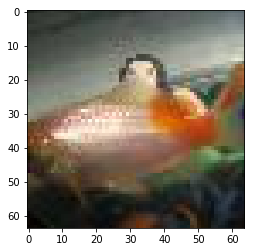

In [37]:
tf.reset_default_graph()

Y = tf.placeholder(tf.uint8 ,[None , 64,64,3])

is_training = tf.placeholder(tf.bool)

print (Y_train.shape)

with tf.variable_scope("model") as scope:
    #hsv_out,rgb_out,hsv_in,rgb_in = baselinish2(Y,is_training)
    hsv_out,rgb_out,hsv_in,rgb_in = complex_pokemon_model2(Y,is_training)
    loss = tf.reduce_mean(tf.square(rgb_out-rgb_in))
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.98, staircase=True)
# Passing global_step to minimize() will increment it at each step.
    train_step = (tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step))
    #optimiser = tf.train.AdamOptimizer(1e-3)
    #train_step = optimiser.minimize(loss)


sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/image_net_pok_model_trained/new_model')
import matplotlib.pyplot as plt
import numpy.random as rnd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


rand_indices = np.random.choice(100,48)
samp = Y_train[rand_indices]

feed_dict = {Y:samp,is_training:True}
losses,rgb_o,rgb_i = sess.run([loss,rgb_out,rgb_in],feed_dict)
print (losses)
show_images(rgb2gray(rgb_i[0]),gray = True)
show_images(rgb_o[0])
show_images(rgb_i[0])

    

589824
12288
0.963955601056


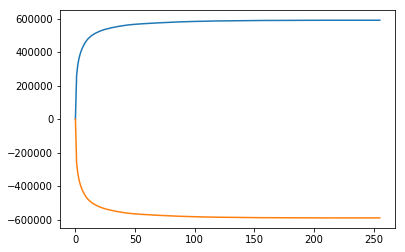

In [38]:
print(rgb_i.size)
print(rgb_o[0].size)
auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_o, [48, 64, 64, 3]))
print(ans)

plt.plot(auc)
plt.plot(1-auc)

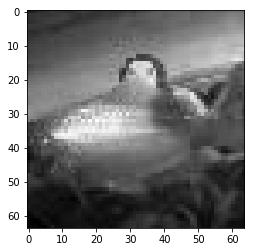

(196608, 3)


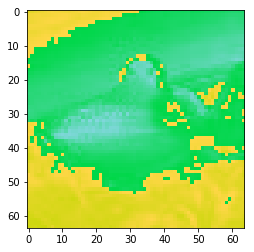

In [60]:
converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
grayscale = np.reshape(rgb_i, [48*64*64, 3]).dot(converter)
grayscale[:,1:3] = -0.1
grayscale_vis = np.reshape(grayscale,[48,64,64,3])
show_images(grayscale_vis[0,:,:,0],gray = True)
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])
rgb_gray = grayscale.dot(inv_mat)
print(rgb_gray.shape)
rgb_gray = np.reshape(rgb_gray, [48,64,64,3])
#print(np.reshape(rgb_gray, [48,64,64,3]).shape)
show_images(rgb_gray[0])

0.687487840652


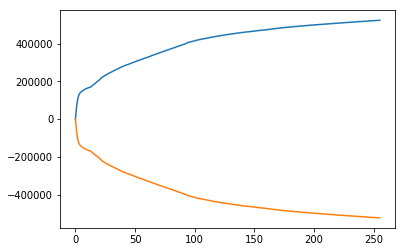

In [61]:
auc, ans = AUC(np.reshape(rgb_i, [48, 64, 64, 3]), np.reshape(rgb_gray, [48, 64, 64, 3]))
print(ans)

plt.plot(auc)
plt.plot(1-auc)